### Video link
https://youtu.be/kCc8FmEb1nY

In [23]:
project_folder = "./"

import torch
from matplotlib import pyplot as plt

from typing import Optional

torch.manual_seed(42)

## The Bigram Model

### Initial comments before implementation

* The bigram model explanation
    * The meaning of __(B, T, C)__ - (*batch*, *time*, *channel*). **Batch** coordinate says at which batch are we. **Time** coordinate says at which position in the text are we. **Channel** says the index of the next characted, probab of which occurrence is encoded.

In [7]:
import utils.dataparse as dataparse

with dataparse.get_file(
    "https://raw.githubusercontent.com/karpathy/ng-video-lecture/master/input.txt",
    project_folder + "data/input.txt"
) as names:
    text = names.read()

text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

The link to the nice repo

https://github.com/0ssamaak0/Karpathy-Neural-Networks-Zero-to-Hero/blob/master/nanoGPT/part6_nano_gpt.ipynb

In [12]:
chars = sorted(set(text))
vocab_size = len(chars)

print("chars", ''.join(chars))
print("vocab_size", vocab_size)

chars 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab_size 65


In [14]:
stoi = { c:i for i,c in enumerate(chars) }
itos = { i:c for c,i in stoi.items() }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join(itos[i] for i in l)

print(encode("world"), decode(encode("world")))

[61, 53, 56, 50, 42] world


In [17]:
data = torch.tensor(encode(text))
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

### Train-validation split

In [18]:
n = int(.9 * len(data))
train_data = data[:n]
val_data = data[n:]

train_data.shape, val_data.shape

(torch.Size([1003854]), torch.Size([111540]))

#### Dataloader

In [19]:
block_size = 8
train_data[:block_size + 1], train_data[:block_size + 1].shape

(tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]), torch.Size([9]))

In [20]:
batch_size = 4
block_size = 8

def get_batch(split: str) -> tuple[torch.Tensor, torch.Tensor]:
    data = train_data if split == "train" else val_data
    # Random indexes for starts of batch elements
    ix = torch.randint(len(data) - block_size, (batch_size,))

    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x, y

xb,yb = get_batch("train")
xb, yb

(tensor([[ 1, 58, 46, 43,  1, 46, 59, 51],
         [57,  1, 63, 53, 59,  1, 57, 39],
         [53, 63, 44, 59, 50, 50, 63,  1],
         [42,  1, 59, 54, 53, 52,  0, 58]]),
 tensor([[58, 46, 43,  1, 46, 59, 51, 40],
         [ 1, 63, 53, 59,  1, 57, 39, 63],
         [63, 44, 59, 50, 50, 63,  1, 61],
         [ 1, 59, 54, 53, 52,  0, 58, 46]]))

### Implementation

In [50]:
class BigramLM(torch.nn.Module):
    def __init__(self, vocab_size: int) -> None:
        super().__init__()
        self.token_embeddings = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        # idx should have dimensionality of (Batches, Time at the text)
        logits = self.token_embeddings(idx) # (B, T, C) = (4, 8, vocab_size)

        if targets is None:
            loss = None
        else:
            # Converting into shapes (N, C) and (N)
            # https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = torch.nn.functional.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx: torch.Tensor, max_new_tokens: int):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # (B, 1, C)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1, 1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [52]:
m = BigramLM(vocab_size)
# m.generate(torch.tensor([[[]]], dtype=int), 10)

logits, loss = m(xb, yb)
loss

tensor(4.6427, grad_fn=<NllLossBackward0>)

### Training

In [54]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
losses = []

2.517594575881958

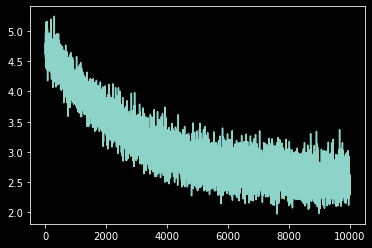

In [55]:
for i in range(int(1e4)):
    xb, yb = get_batch("train")
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
losses[-1]

In [56]:
idx = torch.zeros((1, 1), dtype=torch.long)
generated = m.generate(idx, 400)
print(decode(generated[0].tolist()))



TILBuliner rese, s


RQEbe;$uck. orur l shed oce ff,bbuthaJAG budyos dwn s farad
'ds Ime itlyar:
Wer HAPEEqZ
Tgigag cave thee arinoxxX

Ondw&CO
S:
NOUSHIO:-RGHARAS:
' mby; ye owe, ph bue-
Yen ind.E--gleaz.
Thed
Eored or f?
As t?igruside at I he lald muise;I tobll:
LYCELICNDUn OMusgorubatarms ty ay ther agranndwngis. far cy?
S:
JOZY$R:
CIUD:ich grathppe inthe e.

Frlr pVE:te ThokenbjYol y$Nodlor w


## The self attention math trick

In [11]:
torch.manual_seed(42)

A = torch.tril(torch.ones(3, 3))
print(f"{A=}\n")

A = A / torch.sum(A, 1, keepdim=True)
print(f"{A=}\n")


B = torch.randint(0, 10, (3, 2)).float()
print(f"{B=}\n")

print(f"C == {A @ B}")

A=tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

A=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

B=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

C == tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


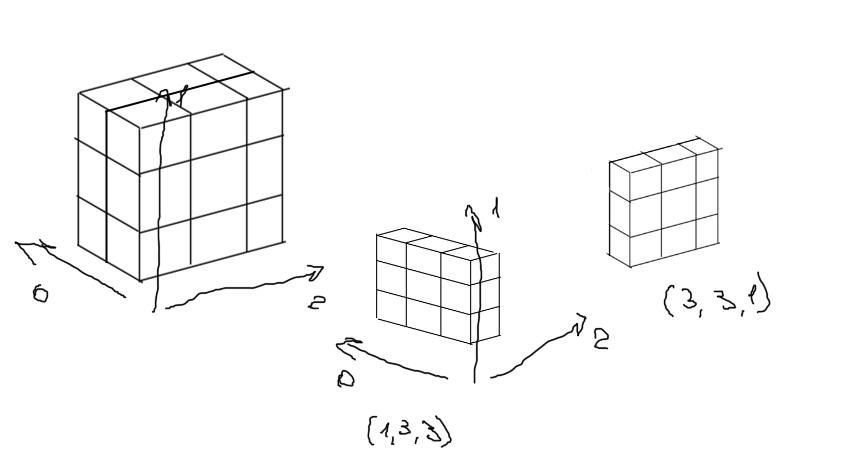

In [31]:
torch.manual_seed(42)
M = torch.randint(0, 10, (2, 2, 2)).float()
print(M[0])

B = torch.ones(2, 2) / 2

print(M @ B[None, ...])

print(M @ B)

print(M @ B[..., None])
print(M.shape, B[..., None].shape)

tensor([[2., 7.],
        [6., 4.]])
tensor([[[4.5000, 4.5000],
         [5.0000, 5.0000]],

        [[5.5000, 5.5000],
         [2.0000, 2.0000]]])
tensor([[[4.5000, 4.5000],
         [5.0000, 5.0000]],

        [[5.5000, 5.5000],
         [2.0000, 2.0000]]])
tensor([[[4.5000],
         [5.0000]],

        [[5.5000],
         [2.0000]]])
torch.Size([2, 2, 2]) torch.Size([2, 2, 1])


In [57]:
torch.manual_seed(42)

A = torch.tril(torch.ones(3, 3))
print(f"{A=}\n")

A = A / torch.sum(A, 1, keepdim=True)
print(f"{A=}\n")

B = torch.randint(0, 10, (3, 2)).float()
print(f"{B=}\n")

print(f"C == {A @ B}")

A=tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

A=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

B=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

C == tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


### Using softmax

In [61]:
# Testing values
B, T, C = 4, 8, 2  # batch size, time, channels
x = torch.rand(B, T, C)

In [63]:
tril = torch.tril(torch.ones(T, T))

wei = torch.zeros(T, T)
wei = wei.masked_fill(tril == 0, float("-inf"))
print(wei)

wei = torch.nn.functional.softmax(wei, dim=-1) # 1/sum(exp(wei))
print(wei)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
